In [1]:
import numpy as np
import pandas as pd

In [2]:
import consts
import util

In [3]:
dataset = pd.read_csv('../data/arc_ms_spec_ordered.csv', index_col=0)
dataset

,Floral,Fruity,Herbal,Green,Woody,Sweet,Balsamic,Earth,Spicy,Chemical,...,273,322,1,314,317,318,319,320,300,0
107,0,0,0,0,0,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126,0,0,0,0,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
240,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5372353,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5372813,0,0,1,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5373729,1,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6040503,1,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
possible_target_cols = consts.POSSIBLE_TARGET_COLS
# target_cols = consts.TARGET_COLS
target_cols = possible_target_cols
target_cols

array(['Floral', 'Fruity', 'Herbal', 'Green', 'Woody', 'Sweet',
       'Balsamic', 'Earth', 'Spicy', 'Chemical', 'Animalic', 'Nutty'],
      dtype='<U8')

In [46]:
# feature_cols = dataset.columns[possible_target_cols.shape[0]:possible_target_cols.shape[0]+consts.ZERO_NUM_FEATURE_COLS_999]
# feature_cols = dataset.columns[possible_target_cols.shape[0]:possible_target_cols.shape[0]+326]
# feature_cols = dataset.columns[possible_target_cols.shape[0]:]

# feature_cols = dataset.columns[possible_target_cols.shape[0]:]
feature_cols = dataset.columns[possible_target_cols.shape[0]:possible_target_cols.shape[0]+194]
feature_cols

Index(['43', '41', '57', '91', '55', '69', '71', '105', '56', '81',
       ...
       '268', '304', '285', '49', '183', '186', '48', '35', '37', '188'],
      dtype='object', length=194)

In [47]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

# Define your MLP model
class MLP(nn.Module):
    def __init__(self, input_size, output_size, layer_size, num_hidden_layers):
        super(MLP, self).__init__()
        torch.manual_seed(consts.TORCH_MANUAL_SEED)
        self.fc_in = nn.Linear(input_size, layer_size)
        self.relu = nn.ReLU()
        self.hidden_fcs = nn.ModuleList([nn.Linear(layer_size, layer_size) for _ in range(num_hidden_layers)])
        self.fc_out = nn.Linear(layer_size, output_size)

    def forward(self, x):
        x = self.fc_in(x)
        x = self.relu(x)
        for fc in self.hidden_fcs:
            x = fc(x)
            x = self.relu(x)
        x = self.fc_out(x)

        return x

# Define custom PyTorch dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Define training function
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

In [66]:
num_hidden_layers = 0
layer_size = 128
lr = 0.001
weight_decay = 0.005
batch_size = 64
BCE_weights_power = 0.5
BCE_weights_factor = 1.2
epochs = 40

In [67]:
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

# Prepare data
positive_dataset = dataset.loc[(dataset[target_cols] != 0).any(axis=1)]
features = positive_dataset[feature_cols].apply(util.normalize_column, axis=0).fillna(0).values
labels = positive_dataset[target_cols].values

THRESHOLDS = [0.65, 0.7, 0.75, 0.8, 0.85]

METRICS = ['acc', 'hamm', 'prec', 'sens', 'f1', 'aps']

eval_stats = {'loss': {'train': [], 'val': []}}
for metric in METRICS:
    eval_stats[metric] = {'train': {t: [] for t in THRESHOLDS},
                          'val': {t: [] for t in THRESHOLDS}}


# Initialize cross-validation
kf = KFold(n_splits=consts.KFOLDS, shuffle=True, random_state=consts.KFOLD_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an empty list to store parameters
all_model_params = []
# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(features, labels)):
    print(f'Fold {fold + 1}')

    # Split data into train and validation sets
    train_features, val_features = features[train_idx], features[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    # Create DataLoader for training and validation
    train_dataset = CustomDataset(train_features, train_labels)
    val_dataset = CustomDataset(val_features, val_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model, criterion, and optimizer
    model = MLP(input_size=len(feature_cols), output_size=len(target_cols), layer_size=layer_size, num_hidden_layers=num_hidden_layers).to(device)
    # criterion = nn.BCELoss()
    possible_label_occurences = torch.tensor(positive_dataset[possible_target_cols].mean())
    indices = np.where(np.isin(possible_target_cols, target_cols))[0]
    label_occurences = possible_label_occurences[indices]

    bce_positive_weights = util.calc_bce_positive_weights(label_occurences, 0.6, 1.2)

    print(bce_positive_weights)
    criterion = nn.BCEWithLogitsLoss(pos_weight=bce_positive_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop
    eval_stats_fold = {'loss': {'train': [], 'val': []}}
    for metric in METRICS:
        eval_stats_fold[metric] = {'train': {t: [] for t in THRESHOLDS},
                            'val': {t: [] for t in THRESHOLDS}}


    for epoch in tqdm(range(epochs), desc="Epoch"):
        eval_stats_fold['loss']['train'].append(train_model(model, train_loader, criterion, optimizer, device))
        eval_stats_fold['loss']['val'].append(util.evaluate_loss(model, val_loader, criterion, device))

        # Calculate and store specuracy
        # accuracy, hamm, precision, sensitivity, f1, aps
        for t in THRESHOLDS:
            eval_train = util.evaluate_metrics(model, train_loader, device, t)
            eval_val = util.evaluate_metrics(model, val_loader, device, t)
            for i, metric in enumerate(METRICS):
                eval_stats_fold[metric]['train'][t].append(eval_train[i])
                eval_stats_fold[metric]['val'][t].append(eval_val[i])

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {eval_stats_fold['loss']['train'][-1]:.4f}, Val Loss: {eval_stats_fold['loss']['val'][-1]:.4f}")
            #   , Train spec: {train_sen:.4f}, Val spec: {val_sen:.4f}")

    eval_stats['loss']['train'].append(eval_stats_fold['loss']['train'])
    eval_stats['loss']['val'].append(eval_stats_fold['loss']['val'])
    for metric in METRICS:
        for t in THRESHOLDS:
            eval_stats[metric]['train'][t].append(eval_stats_fold[metric]['train'][t])
            eval_stats[metric]['val'][t].append(eval_stats_fold[metric]['val'][t])

    # Append parameters of the trained model
    all_model_params.append(model.state_dict())

Fold 1
tensor([ 2.9587,  2.7026,  3.6830,  4.0546,  5.1978,  4.3992,  7.1823,  7.6454,
         7.5900,  5.9367,  7.5900, 10.8152], dtype=torch.float64)


/var/folders/zp/1226jyvd1ws1q507lfnb8kmm0000gn/T/ipykernel_28298/2024072161.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  possible_label_occurences = torch.tensor(positive_dataset[possible_target_cols].mean())


Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40, Train Loss: 1.1011, Val Loss: 1.0917
Epoch 2/40, Train Loss: 1.0308, Val Loss: 1.0644
Epoch 3/40, Train Loss: 0.9846, Val Loss: 1.0473
Epoch 4/40, Train Loss: 0.9465, Val Loss: 1.0344
Epoch 5/40, Train Loss: 0.9158, Val Loss: 1.0269
Epoch 6/40, Train Loss: 0.8890, Val Loss: 1.0238
Epoch 7/40, Train Loss: 0.8655, Val Loss: 1.0186
Epoch 8/40, Train Loss: 0.8422, Val Loss: 1.0173
Epoch 9/40, Train Loss: 0.8214, Val Loss: 1.0155
Epoch 10/40, Train Loss: 0.8024, Val Loss: 1.0161
Epoch 11/40, Train Loss: 0.7841, Val Loss: 1.0212
Epoch 12/40, Train Loss: 0.7671, Val Loss: 1.0251
Epoch 13/40, Train Loss: 0.7510, Val Loss: 1.0285
Epoch 14/40, Train Loss: 0.7365, Val Loss: 1.0324
Epoch 15/40, Train Loss: 0.7237, Val Loss: 1.0359
Epoch 16/40, Train Loss: 0.7114, Val Loss: 1.0402
Epoch 17/40, Train Loss: 0.7003, Val Loss: 1.0448
Epoch 18/40, Train Loss: 0.6901, Val Loss: 1.0485
Epoch 19/40, Train Loss: 0.6800, Val Loss: 1.0497
Epoch 20/40, Train Loss: 0.6716, Val Loss: 1.0547
Epoch 21/

/var/folders/zp/1226jyvd1ws1q507lfnb8kmm0000gn/T/ipykernel_28298/2024072161.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  possible_label_occurences = torch.tensor(positive_dataset[possible_target_cols].mean())


Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40, Train Loss: 1.1059, Val Loss: 1.0646
Epoch 2/40, Train Loss: 1.0396, Val Loss: 1.0320
Epoch 3/40, Train Loss: 0.9948, Val Loss: 1.0110
Epoch 4/40, Train Loss: 0.9588, Val Loss: 0.9946
Epoch 5/40, Train Loss: 0.9284, Val Loss: 0.9827
Epoch 6/40, Train Loss: 0.9018, Val Loss: 0.9763
Epoch 7/40, Train Loss: 0.8785, Val Loss: 0.9701
Epoch 8/40, Train Loss: 0.8557, Val Loss: 0.9636
Epoch 9/40, Train Loss: 0.8356, Val Loss: 0.9630
Epoch 10/40, Train Loss: 0.8171, Val Loss: 0.9607
Epoch 11/40, Train Loss: 0.8005, Val Loss: 0.9611
Epoch 12/40, Train Loss: 0.7853, Val Loss: 0.9626
Epoch 13/40, Train Loss: 0.7705, Val Loss: 0.9600
Epoch 14/40, Train Loss: 0.7554, Val Loss: 0.9623
Epoch 15/40, Train Loss: 0.7415, Val Loss: 0.9643
Epoch 16/40, Train Loss: 0.7285, Val Loss: 0.9664
Epoch 17/40, Train Loss: 0.7172, Val Loss: 0.9708
Epoch 18/40, Train Loss: 0.7064, Val Loss: 0.9712
Epoch 19/40, Train Loss: 0.6956, Val Loss: 0.9747
Epoch 20/40, Train Loss: 0.6855, Val Loss: 0.9802
Epoch 21/

/var/folders/zp/1226jyvd1ws1q507lfnb8kmm0000gn/T/ipykernel_28298/2024072161.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  possible_label_occurences = torch.tensor(positive_dataset[possible_target_cols].mean())


Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40, Train Loss: 1.1041, Val Loss: 1.0711
Epoch 2/40, Train Loss: 1.0372, Val Loss: 1.0450
Epoch 3/40, Train Loss: 0.9939, Val Loss: 1.0293
Epoch 4/40, Train Loss: 0.9567, Val Loss: 1.0170
Epoch 5/40, Train Loss: 0.9257, Val Loss: 1.0064
Epoch 6/40, Train Loss: 0.8998, Val Loss: 0.9999
Epoch 7/40, Train Loss: 0.8764, Val Loss: 0.9987
Epoch 8/40, Train Loss: 0.8550, Val Loss: 1.0019
Epoch 9/40, Train Loss: 0.8354, Val Loss: 1.0035
Epoch 10/40, Train Loss: 0.8164, Val Loss: 1.0067
Epoch 11/40, Train Loss: 0.7990, Val Loss: 1.0099
Epoch 12/40, Train Loss: 0.7823, Val Loss: 1.0122
Epoch 13/40, Train Loss: 0.7676, Val Loss: 1.0148
Epoch 14/40, Train Loss: 0.7536, Val Loss: 1.0229
Epoch 15/40, Train Loss: 0.7418, Val Loss: 1.0326
Epoch 16/40, Train Loss: 0.7283, Val Loss: 1.0351
Epoch 17/40, Train Loss: 0.7167, Val Loss: 1.0487
Epoch 18/40, Train Loss: 0.7051, Val Loss: 1.0593
Epoch 19/40, Train Loss: 0.6950, Val Loss: 1.0619
Epoch 20/40, Train Loss: 0.6859, Val Loss: 1.0715
Epoch 21/

/var/folders/zp/1226jyvd1ws1q507lfnb8kmm0000gn/T/ipykernel_28298/2024072161.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  possible_label_occurences = torch.tensor(positive_dataset[possible_target_cols].mean())


Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40, Train Loss: 1.0969, Val Loss: 1.0992
Epoch 2/40, Train Loss: 1.0273, Val Loss: 1.0768
Epoch 3/40, Train Loss: 0.9813, Val Loss: 1.0619
Epoch 4/40, Train Loss: 0.9426, Val Loss: 1.0519
Epoch 5/40, Train Loss: 0.9114, Val Loss: 1.0462
Epoch 6/40, Train Loss: 0.8844, Val Loss: 1.0422
Epoch 7/40, Train Loss: 0.8604, Val Loss: 1.0390
Epoch 8/40, Train Loss: 0.8384, Val Loss: 1.0420
Epoch 9/40, Train Loss: 0.8176, Val Loss: 1.0443
Epoch 10/40, Train Loss: 0.7989, Val Loss: 1.0418
Epoch 11/40, Train Loss: 0.7831, Val Loss: 1.0478
Epoch 12/40, Train Loss: 0.7665, Val Loss: 1.0537
Epoch 13/40, Train Loss: 0.7519, Val Loss: 1.0566
Epoch 14/40, Train Loss: 0.7380, Val Loss: 1.0634
Epoch 15/40, Train Loss: 0.7249, Val Loss: 1.0698
Epoch 16/40, Train Loss: 0.7117, Val Loss: 1.0794
Epoch 17/40, Train Loss: 0.7002, Val Loss: 1.0870
Epoch 18/40, Train Loss: 0.6891, Val Loss: 1.0910
Epoch 19/40, Train Loss: 0.6789, Val Loss: 1.0999
Epoch 20/40, Train Loss: 0.6697, Val Loss: 1.1073
Epoch 21/

/var/folders/zp/1226jyvd1ws1q507lfnb8kmm0000gn/T/ipykernel_28298/2024072161.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  possible_label_occurences = torch.tensor(positive_dataset[possible_target_cols].mean())


Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40, Train Loss: 1.1058, Val Loss: 1.0677
Epoch 2/40, Train Loss: 1.0366, Val Loss: 1.0371
Epoch 3/40, Train Loss: 0.9924, Val Loss: 1.0169
Epoch 4/40, Train Loss: 0.9554, Val Loss: 1.0005
Epoch 5/40, Train Loss: 0.9242, Val Loss: 0.9927
Epoch 6/40, Train Loss: 0.8982, Val Loss: 0.9879
Epoch 7/40, Train Loss: 0.8736, Val Loss: 0.9846
Epoch 8/40, Train Loss: 0.8507, Val Loss: 0.9836
Epoch 9/40, Train Loss: 0.8305, Val Loss: 0.9847
Epoch 10/40, Train Loss: 0.8122, Val Loss: 0.9875
Epoch 11/40, Train Loss: 0.7941, Val Loss: 0.9889
Epoch 12/40, Train Loss: 0.7775, Val Loss: 0.9937
Epoch 13/40, Train Loss: 0.7626, Val Loss: 0.9976
Epoch 14/40, Train Loss: 0.7479, Val Loss: 1.0029
Epoch 15/40, Train Loss: 0.7350, Val Loss: 1.0087
Epoch 16/40, Train Loss: 0.7227, Val Loss: 1.0122
Epoch 17/40, Train Loss: 0.7105, Val Loss: 1.0161
Epoch 18/40, Train Loss: 0.7000, Val Loss: 1.0281
Epoch 19/40, Train Loss: 0.6898, Val Loss: 1.0308
Epoch 20/40, Train Loss: 0.6812, Val Loss: 1.0365
Epoch 21/

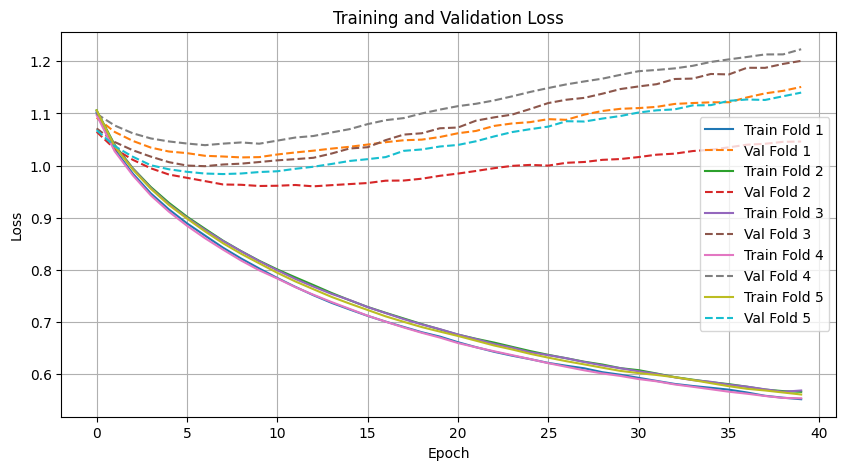

In [68]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
for fold in range(len(eval_stats['loss']['train'])):
    plt.plot(range(epochs), eval_stats['loss']['train'][fold], label=f'Train Fold {fold + 1}')
    plt.plot(range(epochs), eval_stats['loss']['val'][fold], label=f'Val Fold {fold + 1}', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# plt.yscale('log')
plt.show()

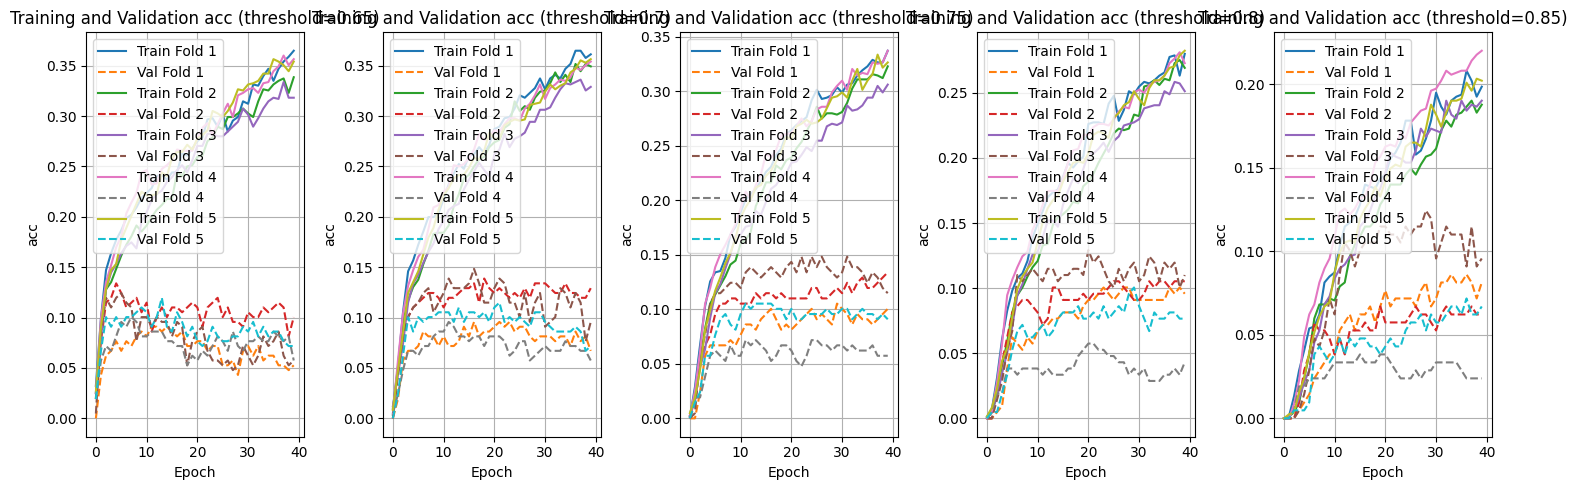

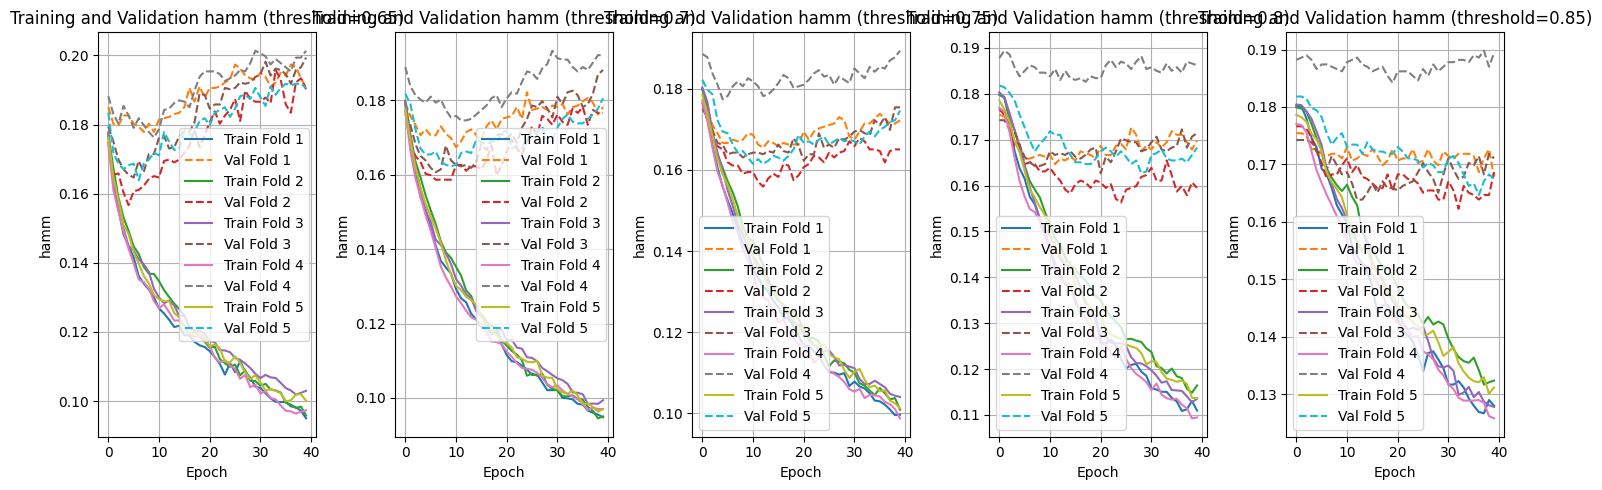

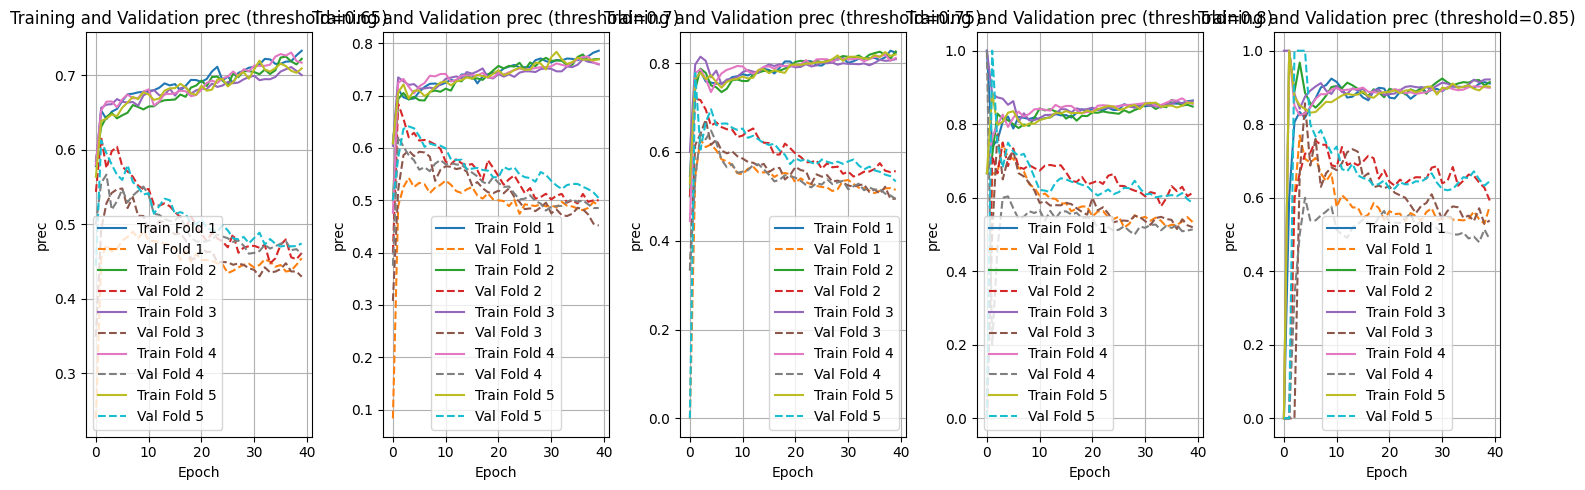

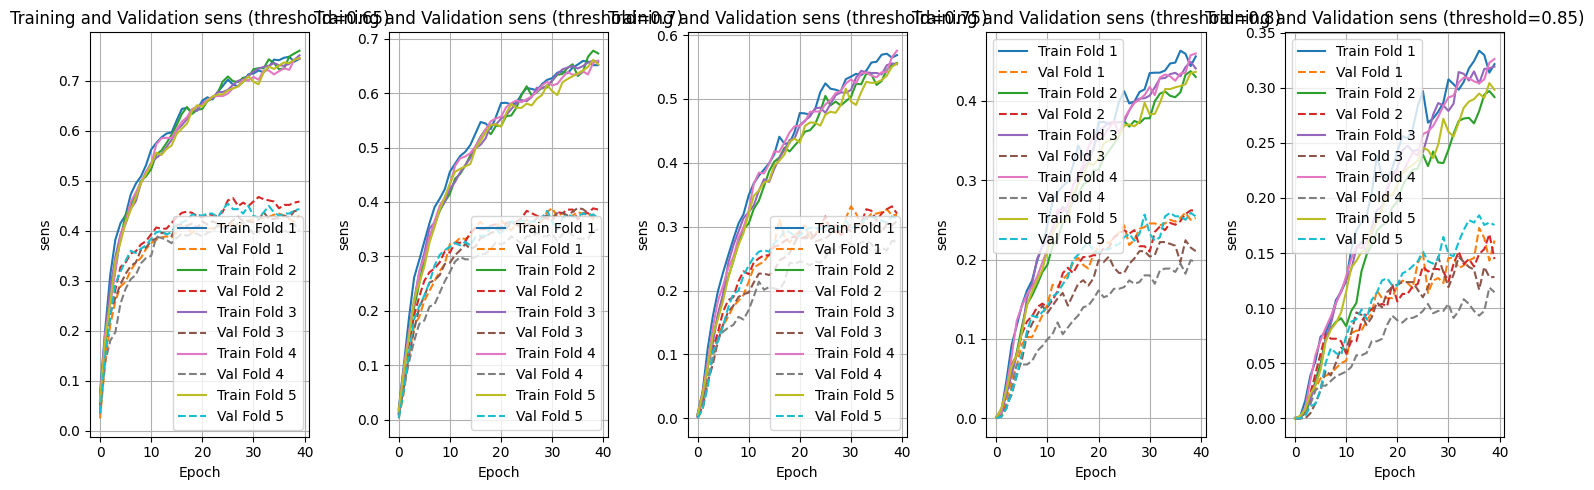

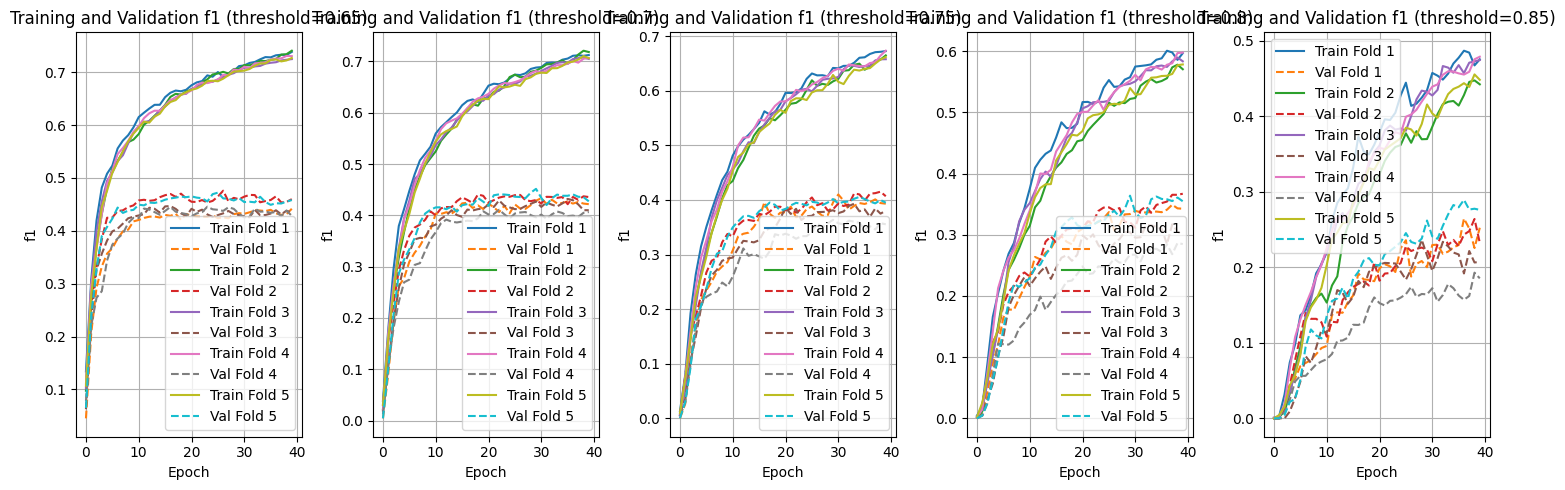

In [69]:
# Plotting
plot_metrics = METRICS.copy()
plot_metrics.remove('aps')
for metric in plot_metrics:
    fig, axs = plt.subplots(1, len(THRESHOLDS), figsize=(15, 5))
    for idx, t in enumerate(THRESHOLDS):
        train_stats_t = eval_stats[metric]['train'][t]
        val_stats_t = eval_stats[metric]['val'][t]

        for fold in range(len(train_stats_t)):
            axs[idx].plot(range(epochs), train_stats_t[fold], label=f'Train Fold {fold + 1}')
            axs[idx].plot(range(epochs), val_stats_t[fold], label=f'Val Fold {fold + 1}', linestyle='--')
        axs[idx].set_title(f'Training and Validation {metric} (threshold={t})')
        axs[idx].set_xlabel('Epoch')
        axs[idx].set_ylabel(f'{metric}')
        axs[idx].grid(True)
        # axs[idx].legend(loc='upper left')
        axs[idx].legend()


    plt.tight_layout()
    plt.show()


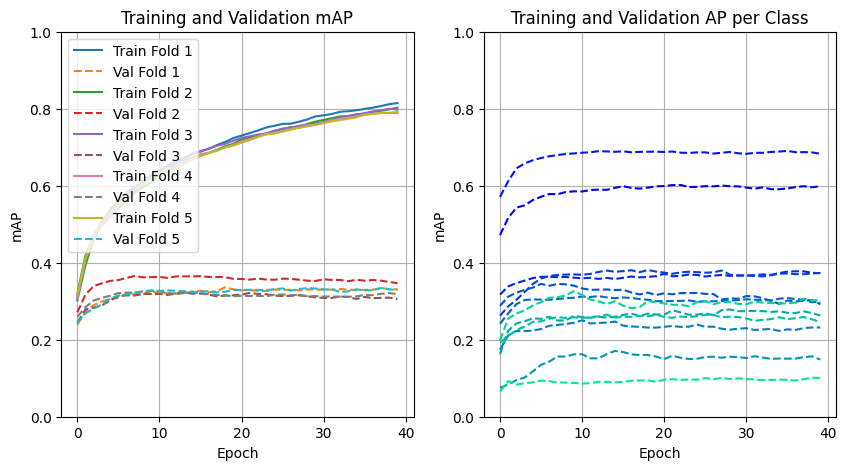

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


train_stats_t = np.array(eval_stats['aps']['train'][t]).mean(axis=-1)
# print(np.array(train_stats_t).shape)
val_stats_t = np.array(eval_stats['aps']['val'][t]).mean(axis=-1)
# print(np.array(val_stats_t).shape)

for fold in range(len(train_stats_t)):
    axs[0].plot(range(epochs), train_stats_t[fold], label=f'Train Fold {fold + 1}')
    axs[0].plot(range(epochs), val_stats_t[fold], label=f'Val Fold {fold + 1}', linestyle='--')

axs[0].set_ylim([0,1])
axs[0].set_title(f'Training and Validation mAP')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('mAP')
axs[0].grid(True)
# axs[0].legend(loc='upper left')
axs[0].legend()





val_stats_t = np.array(eval_stats['aps']['val'][t]).mean(axis=0).T
# Determine the number of smells
num_smells = len(val_stats_t)

# Create a colormap
cmap = plt.cm.winter

# Plot each line with a different color from the colormap
for smell in range(num_smells):
    color = cmap(float(smell) / num_smells)  # Generate a color from the colormap
    axs[1].plot(range(epochs), val_stats_t[smell], label=f'Val Class {smell + 1}', linestyle='--', color=color)

axs[1].set_ylim([0,1])
axs[1].set_title(f'Training and Validation AP per Class')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('mAP')
axs[1].grid(True)
# ax.legend(loc='lower left')

# Show or save the plot
plt.show()  # Or plt.savefig('your_plot.png')

In [71]:
for t in THRESHOLDS:
    print(f'----- Mean t = {t} -----')
    for metric in METRICS:
        val_stats_t = np.array(eval_stats[metric]['val'][t]).mean(axis=0)
        if metric == 'aps':
            metric = 'mAP'
            val_stats_t = val_stats_t.mean(axis=-1)

        print(f'{metric}:\t', val_stats_t[-1])

    print()

aps = np.array(eval_stats['aps']['val'][t]).mean(axis=0)[-1]
print(f'mAP:\t', aps.mean(axis=-1))
print(f'aps:\t', aps)

----- Mean t = 0.65 -----
acc:	 0.06794258373205742
hamm:	 0.19441786283891546
prec:	 0.45585063582745
sens:	 0.4341100369772577
f1:	 0.44438200632901736
mAP:	 0.3260399062465152

----- Mean t = 0.7 -----
acc:	 0.08421052631578949
hamm:	 0.1831738437001595
prec:	 0.48621037053713245
sens:	 0.3703870815182646
f1:	 0.42022268851707184
mAP:	 0.3260399062465152

----- Mean t = 0.75 -----
acc:	 0.09952153110047848
hamm:	 0.17535885167464113
prec:	 0.5187991668300447
sens:	 0.30775738562789
f1:	 0.3861879566530229
mAP:	 0.3260399062465152

----- Mean t = 0.8 -----
acc:	 0.0861244019138756
hamm:	 0.17105263157894737
prec:	 0.5533710423529227
sens:	 0.23521398441618419
f1:	 0.329786946425186
mAP:	 0.3260399062465152

----- Mean t = 0.85 -----
acc:	 0.0660287081339713
hamm:	 0.1728867623604466
prec:	 0.5679875360441843
sens:	 0.14476499831289885
f1:	 0.23053199218806358
mAP:	 0.3260399062465152

mAP:	 0.3260399062465152
aps:	 [0.59878037 0.68321363 0.37301471 0.37340165 0.29229188 0.29902008
 0

In [14]:
----- ms_spectra_ord all_features red_target -----
acc:	 0.1701029082774049
hamm:	 0.23442505592841165
prec:	 0.4479250581193731
sens:	 0.3577737336793363
f1:	     0.39778129351240143
mAP:	 0.35835927526485684


----- ms_spectra_ord red_features red_target -----
acc:	 0.09665071770334928
hamm:	 0.17169059011164273
prec:	 0.5390221672843858
sens:	 0.29479472830903275
f1:	     0.38053938261989134
mAP:	 0.32863630429923574

SyntaxError: invalid syntax (204031980.py, line 1)